In [12]:
source("../src/utils/custom_tools.R")
setup_environment("../src/utils")

In [2]:
impact <- read.table("../data/final_IMPACT_mutations_180508.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [1]:
impact_annotated <- read.table("../data/annotate_with_click_annotvcf/click_annotvcf_IMPACT_mutations_180508.txt",
                               sep = "\t", stringsAsFactors = FALSE, header = TRUE, comment = "#")

# Current

In [2]:
impact_annotated <- impact_annotated[impact_annotated$VEP_Consequence %in% c("missense_variant",
                                              "frameshift_variant",
                                               "stop_gained",
                                               "splice_acceptor_variant",
                                               "inframe_deletion",
                                               "splice_donor_variant",
                                               "inframe_insertion",
                                               "start_lost",
                                               "stop_lost"),]

In [3]:
get_HGVSp_from_vep <- function(HGVSp_string) {
    
    if (is.na(HGVSp_string) | HGVSp_string == "unknown")
        return ("unknown")
    
    HGVSp_string <- strsplit(HGVSp_string, ':')[[1]][2]
    
    protein_long_name <- c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Glu', 'Gln', 'Gly', 'His', 'Ile', 'Leu', 'Lys',
                           'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
    protein_short_name <- c('A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K',
                            'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')
    
    for (name in protein_long_name)
        HGVSp_string <- gsub(name, protein_short_name[match(name, protein_long_name)], HGVSp_string)
    
    HGVSp_string <- gsub('Ter', '*', HGVSp_string)
    HGVSp_string <- gsub('%3D', '=', HGVSp_string)
    
    return (HGVSp_string)
}

impact_annotated$VEP_HGVSp <- sapply(impact_annotated$VEP_HGVSp, get_HGVSp_from_vep)
impact_annotated$VEP_HGVSc <- sapply(impact_annotated$VEP_HGVSc, function(x) strsplit(x, ':')[[1]][2])

* VEP COSMIC: 81

...

* CUSTOM VEP COSMIC_GENE: Gene name
* CUSTOM VEP COSMIC_STRAND: Gene strand
* CUSTOM VEP COSMIC_CDS: CDS annotation
* CUSTOM VEP COSMIC_AA: Peptide annotation
* CUSTOM VEP COSMIC_CNT: How many samples have this mutation
* CUSTOM VEP COSMIC_SNP: classified as SNP

In [35]:
nrow(impact_annotated[! is.na(impact_annotated$VEP_COSMIC_SNP),])

[1] 1002

In [34]:
head(unique(impact_annotated[! is.na(impact_annotated$VEP_COSMIC_SNP),
                             c("VEP_Feature",
                               "VEP_SYMBOL",
                               "VEP_HGVSc",
                               "VEP_HGVSp",
                               "VEP_COSMIC",
                               "VEP_COSMIC_GENE",
                               "VEP_COSMIC_STRAND",
                               "VEP_COSMIC_CDS",
                               "VEP_COSMIC_AA", 
                               "VEP_COSMIC_CNT",
                               "VEP_COSMIC_SNP")]), 200)

,VEP_Feature,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_COSMIC,VEP_COSMIC_GENE,VEP_COSMIC_STRAND,VEP_COSMIC_CDS,VEP_COSMIC_AA,VEP_COSMIC_CNT,VEP_COSMIC_SNP
101,ENST00000355716,TNFRSF14,c.721G>A,p.V241I,COSM4143684,TNFRSF14_ENST00000355716,+,c.721G>A,p.V241I,1,1
111,ENST00000355716,TNFRSF14,c.785C>T,p.P262L,COSM2234252&COSM5134661,TNFRSF14_ENST00000355716&TNFRSF14,+&+,c.785C>T&c.785C>T,p.P262L&p.P262L,1&1,1
390,ENST00000377346,PIK3CD,c.1366A>G,p.T456A,COSM3997717&COSM3997716,PIK3CD_ENST00000536656&PIK3CD,+&+,c.1261A>G&c.1366A>G,p.T421A&p.T456A,1&1,1&1
709,ENST00000361445,MTOR,c.6037A>G,p.S2013G,COSM893803,MTOR,NA,c.6037A>G,p.S2013G,2,1
726,ENST00000361445,MTOR,c.5917A>T,p.I1973F,COSM423441,MTOR,NA,c.5917A>T,p.I1973F,2,1
848,ENST00000361445,MTOR,c.4447T>C,p.C1483R,COSM3747775,MTOR,NA,c.4447T>C,p.C1483R,2,1
1121,ENST00000361445,MTOR,c.985G>A,p.A329T,COSM5227567,MTOR,NA,c.985G>A,p.A329T,2,1
1540,ENST00000375759,SPEN,c.3271C>G,p.L1091V,COSM4597874,SPEN,+,c.3271C>G,p.L1091V,1,1
1679,ENST00000375759,SPEN,c.4775G>A,p.R1592Q,COSM5485487,SPEN,+,c.4775G>A,p.R1592Q,1,1
1861,ENST00000375759,SPEN,c.6709C>G,p.P2237A,COSM5977874,SPEN,+,c.6709C>G,p.P2237A,2,1


In [27]:
head(unique(impact_annotated[! is.na(impact_annotated$VEP_COSMIC) &
                             impact_annotated$VEP_SYMBOL == "KRAS",
                             c("VEP_Feature",
                               "VEP_SYMBOL",
                               "VEP_HGVSc",
                               "VEP_HGVSp",
                               "VEP_COSMIC",
                               "VEP_COSMIC_GENE",
                               "VEP_COSMIC_STRAND",
                               "VEP_COSMIC_CDS",
                               "VEP_COSMIC_AA", 
                               "VEP_COSMIC_CNT",
                               "VEP_COSMIC_SNP")]), 50)

,VEP_Feature,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_COSMIC,VEP_COSMIC_GENE,VEP_COSMIC_STRAND,VEP_COSMIC_CDS,VEP_COSMIC_AA,VEP_COSMIC_CNT,VEP_COSMIC_SNP
21533,ENST00000311936,KRAS,c.520G>A,p.G174S,COSM5374883,KRAS,NA,c.520G>A,p.G174S,1,NA
21538,ENST00000311936,KRAS,c.491G>A,p.R164Q,COSM41307,KRAS,NA,c.491G>A,p.R164Q,2,NA
21541,ENST00000311936,KRAS,c.481C>T,p.R161*,COSM4496753,KRAS,NA,c.481C>T,p.R161*,1,NA
21543,ENST00000311936,KRAS,c.468C>G,p.F156L,COSM5347094,KRAS,NA,c.468C>G,p.F156L,1,NA
21544,ENST00000311936,KRAS,c.466T>C,p.F156L,COSM327842,KRAS,NA,c.466T>C,p.F156L,1,NA
21546,ENST00000311936,KRAS,c.461_463del,p.D154del,COSM1360823,KRAS,NA,c.461_463delATG,p.D154delD,2,NA
21568,ENST00000256078,KRAS,c.437C>T,p.A146V,COSM1360827&COSM19900,KRAS_ENST00000256078&KRAS,-&-,c.437C>T&c.437C>T,p.A146V&p.A146V,13&42,NA
21569,ENST00000256078,KRAS,c.436G>C,p.A146P,COSM1140130&COSM19905,KRAS_ENST00000256078&KRAS,-&-,c.436G>C&c.436G>C,p.A146P&p.A146P,5&10,NA
21570,ENST00000256078,KRAS,c.436G>A,p.A146T,COSM19404&COSM1165198,KRAS&KRAS_ENST00000256078,-&-,c.436G>A&c.436G>A,p.A146T&p.A146T,159&55,NA
21573,ENST00000256078,KRAS,c.418C>T,p.P140S,COSM4169137&COSM4169136,KRAS&KRAS_ENST00000256078,-&-,c.418C>T&c.418C>T,p.P140S&p.P140S,2&2,NA


In [5]:
nrow(impact_annotated[is.na(impact_annotated$VEP_Feature),])

[1] 0

In [6]:
get_cosmic_count_from_custom_vep <- function(data) {
    
    if (is.na(data["VEP_COSMIC_GENE"]) | is.na(data["VEP_COSMIC_CNT"]))
        return (as.integer(0))
    
    transcripts <- strsplit(as.character(data["VEP_COSMIC_GENE"]), '&')[[1]]
    cosmic_counts <- strsplit(as.character(data["VEP_COSMIC_CNT"]), '&')[[1]]
    
    index <- grep(data["VEP_Feature"], transcripts)
    
    if (length(index) == 0)
        return (as.integer(0))
    else
        return (as.integer(cosmic_counts[index]))
}

In [13]:
dd <- apply(impact_annotated, 1, get_cosmic_count_from_custom_vep)
dd <- as.numeric(as.character(dd))
dd[is.na(dd)] <- 0
impact_annotated$cosmic <- dd

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [14]:
head(unique(impact_annotated[! is.na(impact_annotated$VEP_COSMIC) & impact_annotated$VEP_SYMBOL == "CDKN2A",c("VEP_Feature", "VEP_SYMBOL", "VEP_COSMIC_GENE", "VEP_COSMIC_CNT", "cosmic")]), 60)

,VEP_Feature,VEP_SYMBOL,VEP_COSMIC_GENE,VEP_COSMIC_CNT,cosmic
372760,ENST00000498124,CDKN2A,CDKN2A,4,0
372761,ENST00000498124,CDKN2A,CDKN2A,3,0
372762,ENST00000498124,CDKN2A,CDKN2A,1,0
372804,ENST00000498124,CDKN2A,CDKN2A_ENST00000498124,1,1
372844,ENST00000498124,CDKN2A,CDKN2A_ENST00000498124&CDKN2A&CDKN2A_ENST00000446177,1&1&1,1
372857,ENST00000498124,CDKN2A,CDKN2A_ENST00000446177&CDKN2A&CDKN2A_ENST00000498124,1&3&1,1
372877,ENST00000498124,CDKN2A,CDKN2A_ENST00000446177&CDKN2A&CDKN2A_ENST00000498124,1&2&1,1
372879,ENST00000498124,CDKN2A,CDKN2A&CDKN2A_ENST00000498124&CDKN2A_ENST00000446177,5&3&3,3
372882,ENST00000498124,CDKN2A,CDKN2A,2,0
372891,ENST00000498124,CDKN2A,CDKN2A&CDKN2A_ENST00000446177,4&1,0


### `cosmic`

In [15]:
impact_cosmic <- read.table("../data/dominik/all_IMPACT_mutations_180508.simple.hg19_multianno.txt",
                            sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [16]:
# create the impact_kaviar join_key
impact_cosmic$join_key <- paste(impact_cosmic$Chr,
                                impact_cosmic$Start,
                                impact_cosmic$Ref,
                                impact_cosmic$Alt,
                                sep = '_')

**Verification 1** The feature `cosmic70` is unique for each `join_key`:

In [17]:
impact_cosmic <- unique(impact_cosmic[, c("join_key", "cosmic70")])
impact_cosmic %>% group_by(join_key) %>% filter(n() > 1)

join_key,cosmic70


**Verification 2** Every impact `mut_key` has an analoguous `join_key` in `impact_cosmic`:

In [18]:
nrow(impact_annotated[! impact_annotated$ID_VARIANT %in% impact_cosmic$join_key,])

[1] 17396

In [19]:
impact_annotated <- left_join(impact_annotated, impact_cosmic[, c("join_key", "cosmic70")], by = c("ID_VARIANT" = "join_key"))

In [20]:
get_cosmic_count <- function(cosmic_string) {
    cosmic_string <- strsplit(cosmic_string, "OCCURENCE=")[[1]][2]
    cosmic_string <- strsplit(cosmic_string, ',')[[1]]
    cosmic_string <- sapply(cosmic_string, function(element) as.integer(strsplit(element, '\\(')[[1]][1]))
                
    return (sum(cosmic_string))
}

In [21]:
impact_annotated$cosmic70[(impact_annotated$cosmic70 == '.')] <- list('OCCURENCE=0')
impact_annotated$cosmic_count <- sapply(impact_annotated$cosmic70, get_cosmic_count)
impact_annotated$cosmic70 <- NULL

Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message:
“Removed 17396 rows containing missing values (geom_point).”

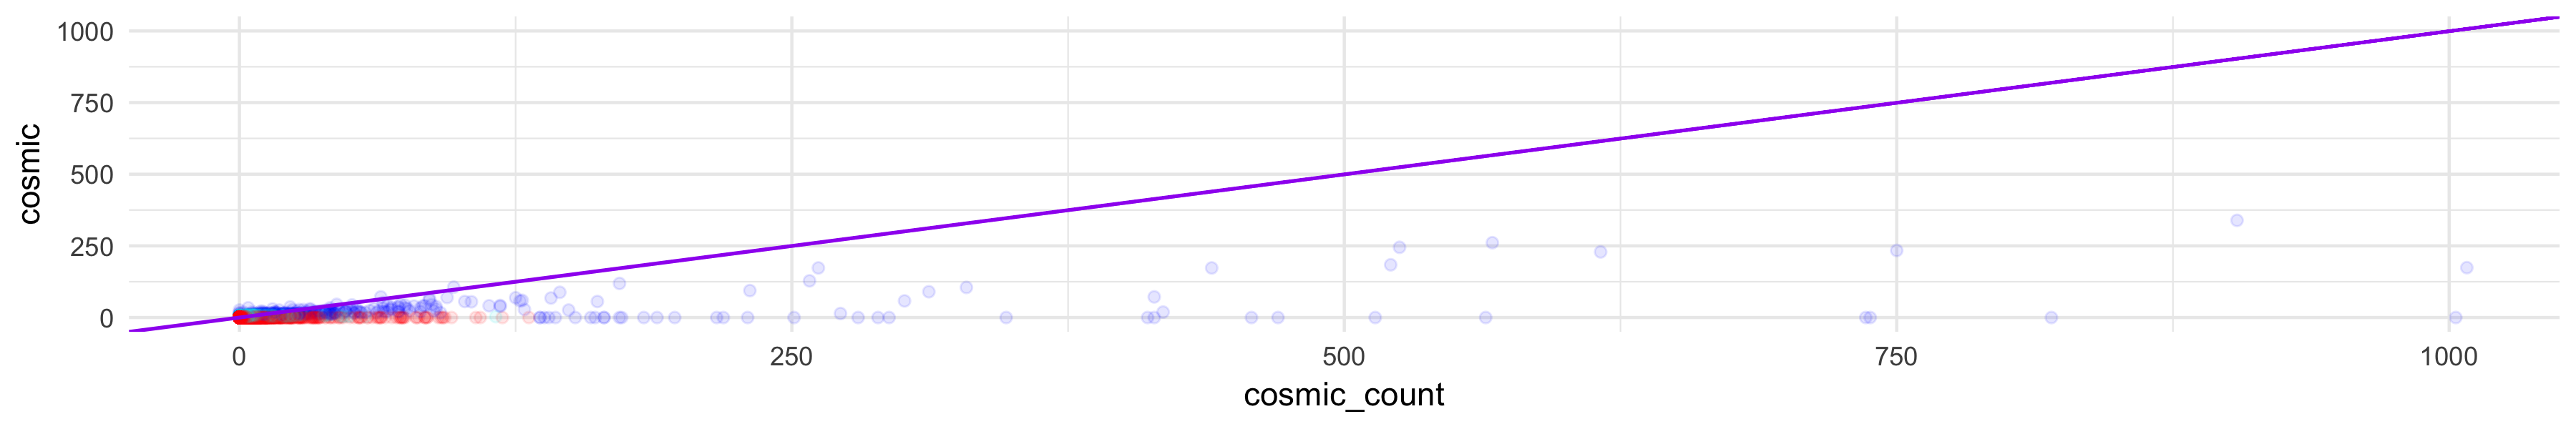

In [22]:
plot_density_2d(impact_annotated, "cosmic_count", "cosmic", points_only = TRUE, height = 2) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6) + coord_cartesian(xlim = c(0, 1000))